In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations

np.random.seed(0)


def softer_softmax(x, axis=-1):
    ndim = K.ndim(x)
    if ndim == 1:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
    elif ndim == 2:
        return K.softmax(x / T)  # normalize with T
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D. '
                         'Received input: %s' % x)


# convert softamx to softer_softmax
def softmax2softer_softmax(x):
    y = []

    for i in range(len(x)):
        distilled_x = []
        distilled_xAppend = distilled_x.append
        for j in range(len(x[0])):
            distilled_xAppend(np.log((x[i][j]) * np.sum(x[i])) / T)  # 적용된 소프트맥스를 역연산하여 원래의 확률을 구하고, T 로 나누어 정규화

        softer_x = []
        softer_xAppend = softer_x.append
        for j in range(len(x[0])):
            softer_xAppend(np.exp(distilled_x[j]) / np.sum(np.exp(distilled_x)))

        y.append(softer_x)
    y = np.array(y)
    return y


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
if len(x_train.shape) == 4:
    img_channels = x_train.shape[3]
else:
    img_channels = 1

input_shape = (img_rows, img_cols, img_channels)
T = 10.0  # T-value
batch_size = 256
epoch = 50  # 증류가 충분히 될 수 있도록 큰 epoch가 필요
dropout_rate = 0.4
teacher_dense = 512
student_dense = 512
num_classes = len(np.unique(y_train))
earlystopping = EarlyStopping(monitor="val_loss", patience=10)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
def teacher_model():
    print("Teacher training start")

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape, activation="relu"))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(teacher_dense, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist = model.fit(x_train, y_train,
                     batch_size=batch_size,
                     epochs=epoch,
                     verbose=0,
                     validation_data=(x_test, y_test),
                     callbacks=[earlystopping])

    return model, hist

In [8]:
# distilled(student) model
def student_model1(teacher_model):
    print("student1 training start")

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape, activation="relu"))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(student_dense, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation=softer_softmax))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    soft_train_labels = softmax2softer_softmax(teacher_model.predict(x_train))  # soft train label
    soft_test_labels = softmax2softer_softmax(teacher_model.predict(x_test))  # soft test label

    hist = model.fit(x_train, soft_train_labels,
                      epochs=epoch,
                      batch_size=batch_size,
                      verbose=0,
                      validation_data=(x_test, soft_test_labels),
                      callbacks=[earlystopping])

    # inference with normal softmax
    model.layers[-1].activation = activations.softmax
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

    print('student1 Test loss:', test_loss)
    print('student1 Test accuracy:', test_acc)

    return hist


# normal model
def student_model2():
    print("normal model training start")

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape, activation="relu"))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(student_dense, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    hist = model.fit(x_train, y_train,
                      epochs=epoch,
                      batch_size=batch_size,
                      verbose=0,
                      validation_data=(x_test, y_test),
                      callbacks=[earlystopping])

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

    print('student2 Test loss:', test_loss)
    print('student2 Test accuracy:', test_acc)

    return hist

In [9]:
teacher, teacher_hist = teacher_model()

hist1 = student_model1(teacher)

hist2 = student_model2()

print("training finish")

Teacher training start
student1 training start


e:\anaconda\envs\data\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


313/313 [==============================] - 1s 3ms/step - loss: 1.3433 - accuracy: 0.8128
student1 Test loss: 1.343270182609558
student1 Test accuracy: 0.8127999901771545
normal model training start
313/313 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.8133
student2 Test loss: 0.60711669921875
student2 Test accuracy: 0.8133000135421753
training finish


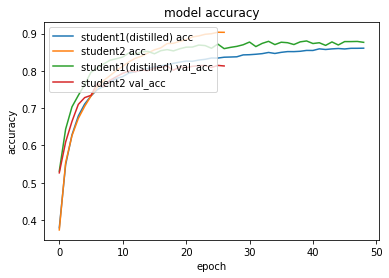

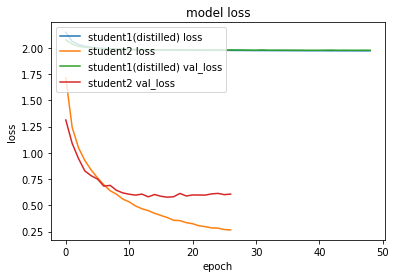

In [11]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['student1(distilled) acc', "student2 acc", 'student1(distilled) val_acc', "student2 val_acc", ], loc='upper left')
plt.show()

plt.plot(hist1.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['student1(distilled) loss', "student2 loss", 'student1(distilled) val_loss', "student2 val_loss"], loc='upper left')
plt.show()